# MLP for NLP Classification
Reference Docs:
- https://colab.research.google.com/drive/1WUy4G2SsoLelrZDkO2I0v9tHx9x27NJK?usp=sharing

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os, gc
import numpy as np
import random
from tqdm import tqdm
import torch
from pympler import asizeof
%matplotlib inline


import json


import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader 
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Sampler

from sqlalchemy.orm import Session
from sqlalchemy import create_engine, select, MetaData, Table, and_

### Settings

In [2]:
with open ('../settings.json') as f:
    settings = json.load(f)

DATA_DIR = os.path.join(settings['data_path'], 'classifier')
os.makedirs(DATA_DIR, exist_ok=True)
CHECKPOINT_DIR = os.path.join(DATA_DIR, "model_data")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
CHECKPOINT_PREFIX = os.path.join(CHECKPOINT_DIR, "mlp_nlp_mal")

db_uri = settings['sqlalchemy_database_uri']

RANDOM_SEED = 4321
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True

VOCABULARY_SIZE = 20000
DROPOUT = 0.25
LEARNING_RATE = 0.0001
EMBEDDING_DIM = 128
BATCH_SIZE = 32
NUM_EPOCHS = 25
NUM_CLASSES = 4
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


### Get Data

In [3]:
from utils.mal_data import get_mal_data
signatures = ['AgentTesla', 'RedLineStealer', 'RaccoonStealer', 'benign']
reports = get_mal_data(signatures)

Loading AgentTesla reports from file
Loading RedLineStealer reports from file
Loading RaccoonStealer reports from file
Loading benign reports from file


In [4]:
# prune long and short reports
for signature in signatures:
    for report in reports:
        if report[1] != 'benign':
            if len(report[0]) < 10000:
                reports.remove(report)
            if len(report[0]) > 100000:
                reports.remove(report)
        else:
            if len(report[0]) < 1000:
                reports.remove(report)
            if len(report[0]) > 10000:
                reports.remove(report)


### Data Discovery and Cleaning

Number ofreports for AgentTesla: 9138
Mean report length for AgentTesla: 48976.565222149264
Median report length for AgentTesla: 49273.0
Min report length for AgentTesla: 10137
Max report length for AgentTesla: 99349
Standard deviation for AgentTesla: 11153.320138035722
Number of outliers: 1959


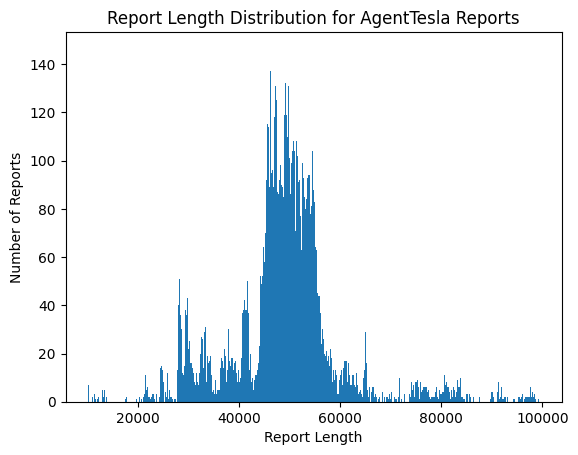

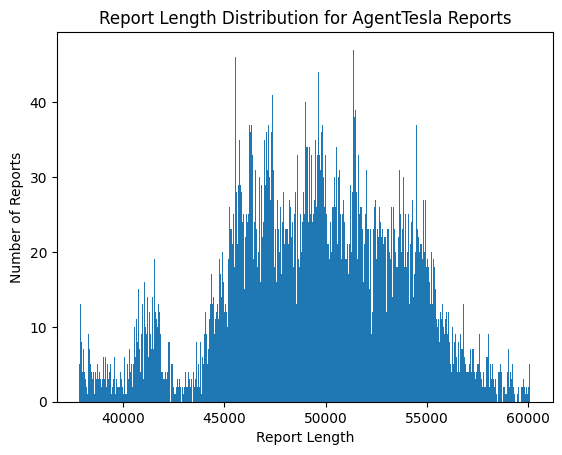

Number ofreports for RedLineStealer: 7540
Mean report length for RedLineStealer: 59589.99880636605
Median report length for RedLineStealer: 69969.5
Min report length for RedLineStealer: 10140
Max report length for RedLineStealer: 99973
Standard deviation for RedLineStealer: 19751.4947799814
Number of outliers: 2632


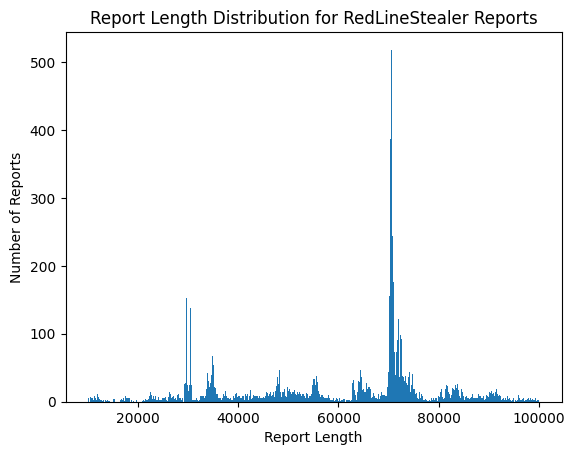

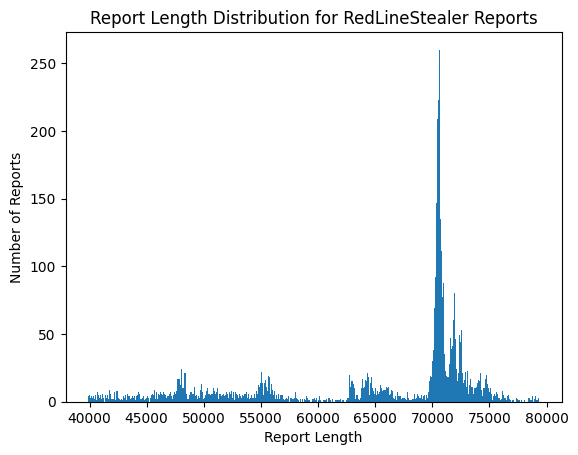

Number ofreports for RaccoonStealer: 8090
Mean report length for RaccoonStealer: 14919.46872682324
Median report length for RaccoonStealer: 12839.0
Min report length for RaccoonStealer: 10433
Max report length for RaccoonStealer: 99409
Standard deviation for RaccoonStealer: 8947.119945172239
Number of outliers: 482


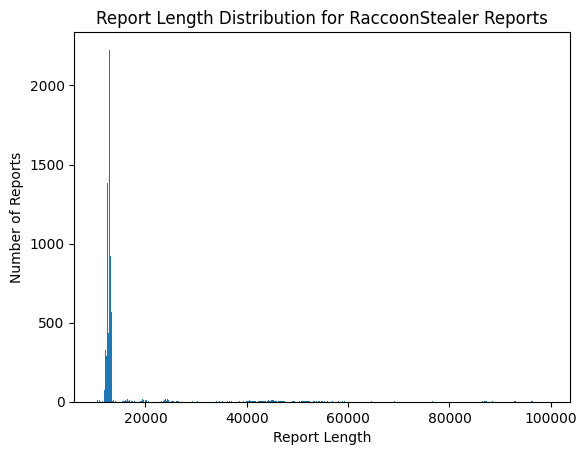

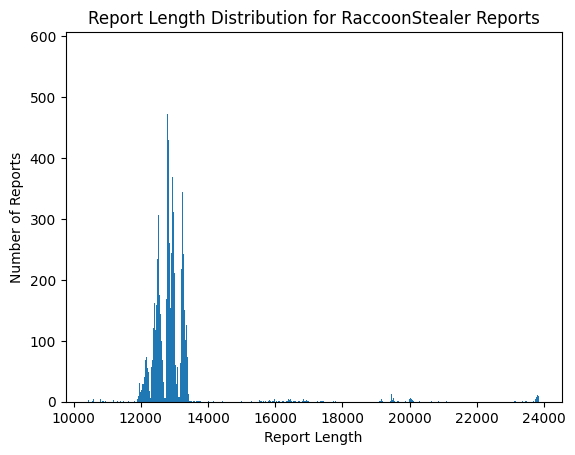

Number ofreports for benign: 7431
Mean report length for benign: 3991.5837706903512
Median report length for benign: 3169.0
Min report length for benign: 1000
Max report length for benign: 9997
Standard deviation for benign: 2408.5365824629707
Number of outliers: 2785


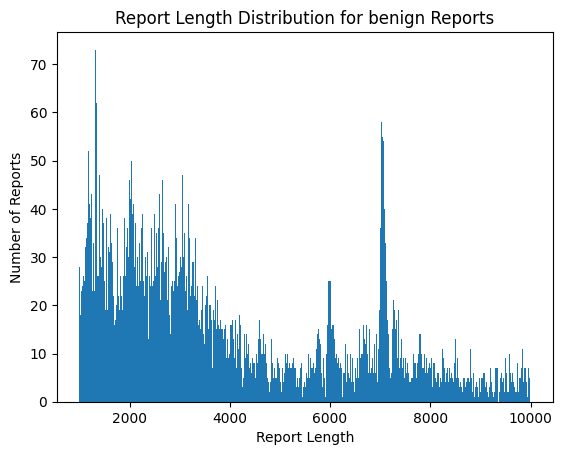

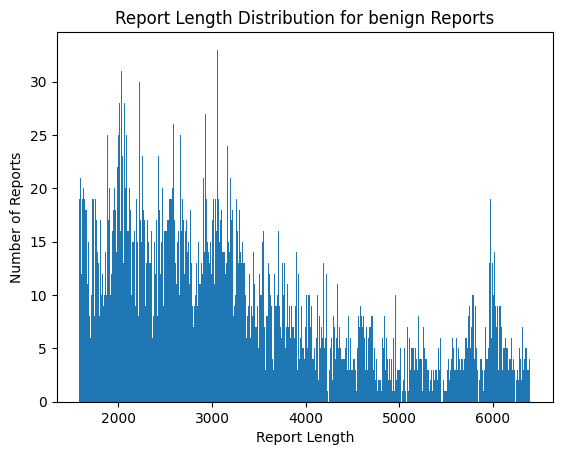

In [5]:
import numpy as np
std_thres = 1

# find the mean, median, min, and max lengths of the reports for each signature
for signature in signatures:
    report_lengths = [len(r[0]) for r in reports if r[1] == signature]
    mean_length = np.mean(report_lengths)
    median_length = np.median(report_lengths)
    min_length = min(report_lengths)
    max_length = max(report_lengths)
    std_dev = np.std(report_lengths)

    print(f"Number ofreports for {signature}: {len(report_lengths)}")
    print(f"Mean report length for {signature}: {mean_length}")
    print(f"Median report length for {signature}: {median_length}")
    print(f"Min report length for {signature}: {min_length}")
    print(f"Max report length for {signature}: {max_length}")
    print(f"Standard deviation for {signature}: {std_dev}")

    # find the outliers in the report lengths based on standard deviation

    outliers = [r for r in report_lengths if (r > mean_length + (std_thres * std_dev) or r < mean_length - (std_thres * std_dev))]
    print(f"Number of outliers: {len(outliers)}")

    # graph distribution of the report lengths before removing outliers
    import matplotlib.pyplot as plt
    plt.hist(report_lengths, bins=500)
    plt.xlabel('Report Length')
    plt.ylabel('Number of Reports')
    plt.title(f'Report Length Distribution for {signature} Reports')
    plt.show()

    # remove outliers
    reports = [r for r in reports if len(r[0]) not in outliers]
    report_lengths = [len(r[0]) for r in reports if r[1] == signature]

    # graph distribution of the report lengths after removing outliers
    plt.hist(report_lengths, bins=500)
    plt.xlabel('Report Length')
    plt.ylabel('Number of Reports')
    plt.title(f'Report Length Distribution for {signature} Reports')
    plt.show()

### Select 4,000 of each class

In [6]:
# print the number of reports for each signature after removing outliers
for signature in signatures:
    report_lengths = [len(r[0]) for r in reports if r[1] == signature]
    print(f"Number of reports for {signature}: {len(report_lengths)}")

# randomly shuffle and select 5000 of each signature
random.shuffle(reports)
selected_reports = []
for signature in signatures:
    selected_reports.extend([r for r in reports if r[1] == signature][:4000])
reports = selected_reports

# print the number of reports for each signature after selecting 4000 of each
for signature in signatures:
    report_lengths = [len(r[0]) for r in reports if r[1] == signature]
    print(f"Number of reports for {signature}: {len(report_lengths)}")

print(f"Total number of reports: {len(reports)}")

Number of reports for AgentTesla: 7080
Number of reports for RedLineStealer: 4884
Number of reports for RaccoonStealer: 7608
Number of reports for benign: 4646
Number of reports for AgentTesla: 4000
Number of reports for RedLineStealer: 4000
Number of reports for RaccoonStealer: 4000
Number of reports for benign: 4000
Total number of reports: 16000


In [7]:
# break into texts and labels
tokenized_texts = [report[0] for report in reports]
labels = [report[1] for report in reports]

# encode labels
label_to_index = {label: i for i, label in enumerate(signatures)}
index_to_label = {i: label for label, i in label_to_index.items()}
labels = [label_to_index[label] for label in labels]

### Build Vocab

In [8]:

def build_vocab(texts):
    """Build vocabulary and find maximum sentence length.
    
    Args:
        texts (List[list]): List of tokenized text data
    
    Returns:
        word2idx (Dict): Vocabulary built from the corpus
        max_len (int): Maximum sentence length
    """

    max_len = 0
    word2idx = {}

    # Add <pad> and <unk> tokens to the vocabulary
    word2idx['<pad>'] = 0
    word2idx['<unk>'] = 1

    # Building our vocab from the corpus starting from index 2
    idx = 2
    for tokenized_sent in tqdm(texts, desc='Building vocab'):

        # Add new token to `word2idx`
        for token in tokenized_sent:
            if token not in word2idx:
                word2idx[token] = idx
                idx += 1

        # Update `max_len`
        max_len = max(max_len, len(tokenized_sent))

    return word2idx, max_len

def encode(tokenized_texts, word2idx, max_len):
    """Pad each sentence to the maximum sentence length and encode tokens to
    their index in the vocabulary.

    Returns:
        input_ids (np.array): Array of token indexes in the vocabulary with
            shape (N, max_len). It will the input of our CNN model.
    """

    input_ids = []
    for tokenized_sent in tqdm(tokenized_texts, desc='Encoding'):
        # Pad sentences to max_len
        tokenized_sent += ['<pad>'] * (max_len - len(tokenized_sent))

        # Encode tokens to input_ids
        input_id = [word2idx.get(token) for token in tokenized_sent]
        input_ids.append(input_id)
    
    return np.array(input_ids)

### Execute above functions

In [9]:
# Tokenize, build vocabulary, encode tokens
print("Tokenizing...\n")
word2idx, max_len = build_vocab(tokenized_texts)
input_ids = encode(tokenized_texts, word2idx, max_len)

Tokenizing...



Encoding: 100%|██████████| 16000/16000 [00:53<00:00, 297.44it/s]


In [10]:
# let's clean up some memory
del tokenized_texts
gc.collect()
del reports
gc.collect()
del word2idx
gc.collect()

0

### Create Dataloaders

In [11]:
from torch.utils.data import (TensorDataset, DataLoader, RandomSampler,SequentialSampler)

def data_loader(train_inputs, val_inputs, test_inputs, train_labels, val_labels, test_labels, batch_size=BATCH_SIZE):
    # Convert data type to torch.Tensor
    train_inputs = torch.tensor(train_inputs)
    val_inputs = torch.tensor(val_inputs)
    test_inputs = torch.tensor(test_inputs)
    train_labels = torch.tensor(train_labels)
    val_labels = torch.tensor(val_labels)
    test_labels = torch.tensor(test_labels)
                                   
    # Create DataLoader for training data
    train_data = TensorDataset(train_inputs, train_labels)
    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

    # Create DataLoader for validation data
    val_data = TensorDataset(val_inputs, val_labels)
    val_sampler = SequentialSampler(val_data)
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

    # create DataLoader for test data
    test_data = TensorDataset(test_inputs, test_labels)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
    return train_dataloader, val_dataloader, test_dataloader

In [12]:
from sklearn.model_selection import train_test_split

# Train Valid Split
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    input_ids, labels, test_size=0.2, random_state=42)

# Valid Test Split
val_inputs, test_inputs, val_labels, test_labels = train_test_split(
    val_inputs, val_labels, test_size=0.5, random_state=42)

In [13]:
# free up some memory
del input_ids
gc.collect()

0

In [14]:

# Load data to PyTorch DataLoader
train_dataloader, val_dataloader, test_dataloader = \
data_loader(train_inputs, val_inputs, test_inputs, train_labels, val_labels, test_labels, batch_size=BATCH_SIZE)

### Function to intialize model and optimizer

### Train Loop

Epoch: 001/025 | Train: 68.51% | Validation: 66.88% | Elapsed: 0.24 min
Epoch: 002/025 | Train: 68.77% | Validation: 67.06% | Elapsed: 0.48 min
Epoch: 003/025 | Train: 68.90% | Validation: 67.31% | Elapsed: 0.71 min
Epoch: 004/025 | Train: 69.08% | Validation: 67.75% | Elapsed: 0.95 min
Epoch: 005/025 | Train: 69.25% | Validation: 68.00% | Elapsed: 1.18 min
Epoch: 006/025 | Train: 93.52% | Validation: 92.88% | Elapsed: 1.42 min
Epoch: 007/025 | Train: 93.63% | Validation: 93.06% | Elapsed: 1.66 min
Epoch: 008/025 | Train: 93.35% | Validation: 92.88% | Elapsed: 1.89 min
Epoch: 009/025 | Train: 93.42% | Validation: 92.88% | Elapsed: 2.13 min
Epoch: 010/025 | Train: 93.42% | Validation: 92.88% | Elapsed: 2.37 min
Epoch: 011/025 | Train: 93.34% | Validation: 92.75% | Elapsed: 2.60 min
Epoch: 012/025 | Train: 93.39% | Validation: 92.81% | Elapsed: 2.84 min
Epoch: 013/025 | Train: 93.39% | Validation: 92.81% | Elapsed: 3.08 min
Epoch: 014/025 | Train: 93.38% | Validation: 92.81% | Elapsed: 3

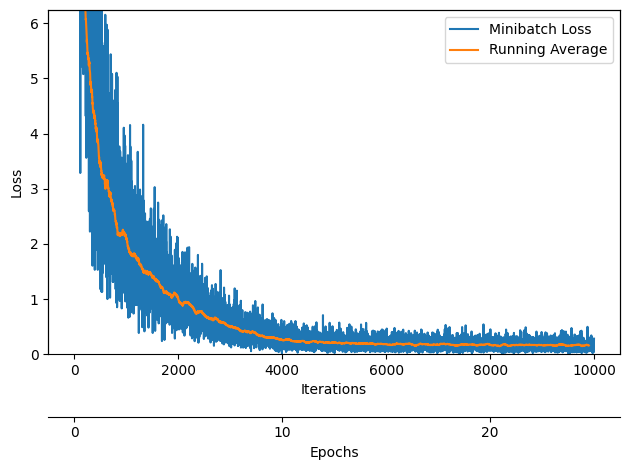

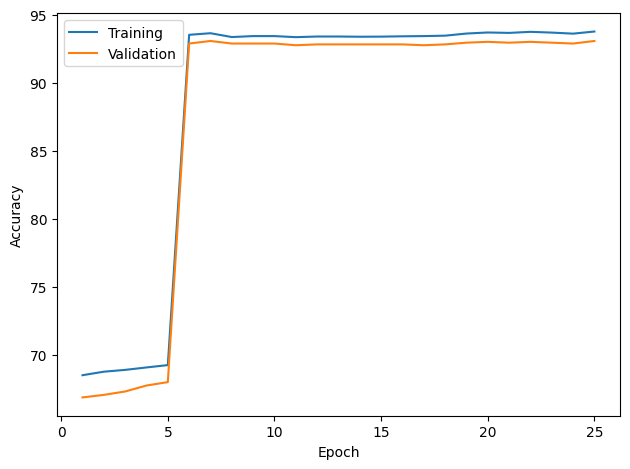

In [16]:
from utils.train import train_model
from utils.plot import plot_accuracy, plot_training_loss
from torch import optim
from models.mlp_nlp import MLP_NLP

model = MLP_NLP(vocab_size=VOCABULARY_SIZE,
                embed_dim=EMBEDDING_DIM,
                num_class=NUM_CLASSES,
                hidden_size1=513,
                hidden_size2=256,
                hidden_size3=128,
                dropout=DROPOUT)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True)

model = model.to(DEVICE)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_dataloader,
    valid_loader=val_dataloader,
    test_loader=test_dataloader,
    optimizer=optimizer,
    checkpoint_prefix=CHECKPOINT_PREFIX,
    device=DEVICE,
    logging_interval=100)

plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_dataloader),
                   results_dir=None,
                   averaging_iterations=100)

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)

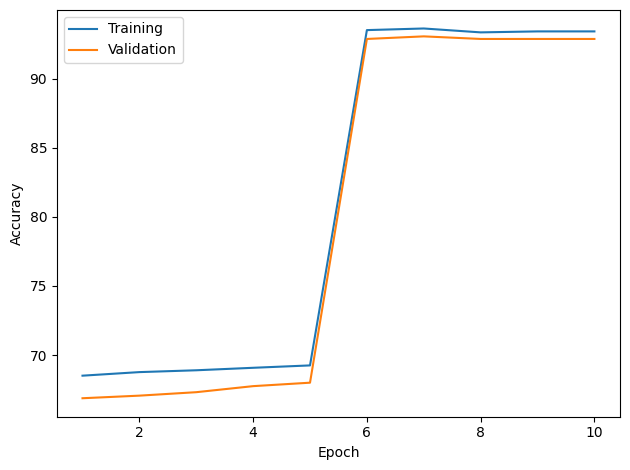

In [17]:
#zoom in on the first 10 epochs
plot_accuracy(train_acc_list=train_acc_list[:10],
              valid_acc_list=valid_acc_list[:10],
              results_dir=None)